In [320]:
import matplotlib.pyplot as plt
import numpy as np

"""In order to provide a better presentation of the graphs we use the rcParams options shown below."""

import matplotlib
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

In [321]:
"""Our system of differential equations belongs to the complex space, that is why we implemented the code suggested in"""
"""https://stackoverflow.com/questions/19910189/scipy-odeint-with-complex-initial-values."""

import time
import numpy as np
from scipy.integrate import odeint
from scipy.special import zeta


def odeintz(func, z0, t, **kwargs):
   
    
    """An odeint-like function for complex valued differential equations.

    Inputs:
    ----------
      -func: function associated to dr/dt=f(x;t), where x is the set of parameters and variables to be determined
      -z0: 1d array with length N*(5N-1)/2
      -t: 1d array from t=0 to t=tf (parameter set by the user)
      - **kwargs: keyword arguments related with external functions to be used in odeint
    
    Return:
      -z: multivariable array with the solution of the differential equation associated with each variable"""

    # Disallow Jacobian-related arguments.
    _unsupported_odeint_args = ['Dfun', 'col_deriv', 'ml', 'mu']
    bad_args = [arg for arg in kwargs if arg in _unsupported_odeint_args]
    if len(bad_args) > 0:
        raise ValueError("The odeint argument %r is not supported by "
                         "odeintz." % (bad_args[0],))

    # Make sure z0 is a numpy array of type np.complex128.
    z0 = np.array(z0, dtype=np.complex128, ndmin=1)

    def realfunc(x, t, *args):
        z = x.view(np.complex128)
        dzdt = func(z, t, *args)
        # func might return a python list, so convert its return
        # value to an array with type np.complex128, and then return
        # a np.float64 view of that array.
        return np.asarray(dzdt, dtype=np.complex128).view(np.float64)

    result = odeint(realfunc, z0.view(np.float64), t, **kwargs)

    if kwargs.get('full_output', False):
        z = result[0].view(np.complex128)
        infodict = result[1]
        return z, infodict
    else:
        z = result.view(np.complex128)
        return z

In [514]:
#length_side=2
#N=length_side**3

N=2
J=1
j=N

refgamma=1 # 0.2  #Fixed
refgammadecay=1
refomega=1


def index_list(N=N):
    Index_list=[]
    for j in range(N+1):
        for k in range(N+1):
            Index_list.append([j,k])
    return Index_list
    


def Aplus_j(n):
    if 0<=n<=N:
        return np.sqrt( (N-n)*  (n+1) )
    else:
        return 0

    
def Aminus_j(n):
    if 0<=n<=N:
        return np.sqrt( (n)*  (N-n+1) )
    else:
        return 0    
    
    
def Az(n):
    return -N/2+n



Gamma_phi=refgamma*J
Gamma_C=refgammadecay*J

Omega=refomega*J

from numba import jit

#@jit



def vectorsR(r, t,J=J,N=N,Omega=Omega,Gamma_C=Gamma_C,Gamma_phi=Gamma_phi):#,Vect=Vect):   
            
    #matrix_zero=np.zeros((int(3*N),int(3*N)),dtype = 'complex_')
    matrix_zero=np.zeros((int( (N+1)**2  ),int((N+1)**2)),dtype = 'complex_')
    
    
    drdt =  np.matmul(matrix_zero, r)  #matrix_zero @ r   #sum of the linear and the constant part
    #drdt = matrix_zero @ r
    
    
    Index_list=index_list(N)
    
    
    ###Define Vect which is an array of coordinates of size N
    
    count=0
       
    
    for vect in Index_list:
        n1  =vect[0]
        npr1=vect[1]
        npr=npr1

            
        cfinnprm1=Index_list.count([n1,npr1-1])
        indnnprm1=Index_list.index(list(cfinnprm1*np.array([n1,npr1-1])))
            
        cfinm1npr=Index_list.count([n1-1,npr1])
        indnm1npr=Index_list.index(list(cfinm1npr*np.array([n1-1,npr1])))
            
        cfinnprp1=Index_list.count([n1,npr1+1])
        indnnprp1=Index_list.index(list(cfinnprp1*np.array([n1,npr1+1])))
            
        cfinp1npr=Index_list.count([n1+1,npr1])
        indnp1npr=Index_list.index(list(cfinp1npr*np.array([n1+1,npr1])))
            
        cfinp1nprp1=Index_list.count([n1+1,npr1+1])
        indnp1nprp1=Index_list.index(list(cfinp1nprp1*np.array([n1+1,npr1+1])))
            
        cfinnpr=Index_list.count([n1,npr1])
        indnnpr=Index_list.index(list(cfinnpr*np.array([n1,npr1])))
        
        
            
        drdt[indnnpr]+=1j*(Omega/2)* Aplus_j(npr1-1)*cfinnprm1*r[indnnprm1]+\
            -1j*(Omega/2)*Aplus_j(n1-1)*cfinm1npr*r[indnm1npr]+1j*(Omega/2)*Aminus_j(npr1+1)*cfinnprp1*r[indnnprp1]+\
            -1j*(Omega/2)*Aminus_j(n1+1)*cfinp1npr*r[indnp1npr]+Gamma_C*Aminus_j(n1+1)*Aminus_j(npr+1)*cfinp1nprp1*r[indnp1nprp1]+\
            2*1j*(J/N)*(Az(npr1)**2-Az(n1)**2)*cfinnpr*r[indnnpr]  -Gamma_phi*( (Az(n1)-Az(npr1))**2 )*cfinnpr*r[indnnpr]+\
            -(Gamma_C/2)*(Aminus_j(n1)*Aplus_j(n1-1) + Aminus_j(npr1)*Aplus_j(npr1-1) )*cfinnpr*r[indnnpr]

               
    return drdt


r0=int((N+1)**2)*[0]

r0[0]=1

rinit=r0


In [515]:
init_time=0
final_time=8
steps=300


times = np.linspace(init_time, final_time, steps)



In [516]:
t0=time.time()

z=odeintz(vectorsR, r0, times)#, args=(N,L))
t1=time.time()

0.09021377563476562 2


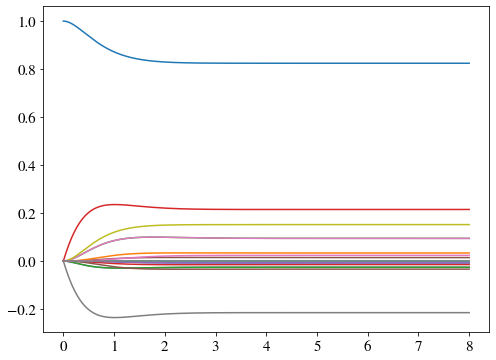

In [517]:
for j in range((N+1)**2):
    plt.plot(times,np.real(z[:,j]))
    plt.plot(times,np.imag(z[:,j]))

print(t1-t0,N)

In [518]:
#z[3,:]  We obtain the third elements of the density matrix

"We can determine the density matrix using the following function"

from numba import jit

#@jit

def rho_matr(time_index):
    rho_matr=np.zeros((int( (N+1)  ),int((N+1))),dtype = 'complex_')
    count=0
    for i in range(N+1):
        for j in range(N+1):
            rho_matr[i][j]= z[time_index,:][count]
            
            count=count+1
            
    return rho_matr

In [519]:
#%timeit rho_matr(60)

In [520]:
def Sxyz_dicke(N=N):
    S_x=np.zeros((int( (N+1)  ),int((N+1))),dtype = 'complex_')
    S_y=np.zeros((int( (N+1)  ),int((N+1))),dtype = 'complex_')
    S_z=np.zeros((int( (N+1)  ),int((N+1))),dtype = 'complex_')

    for n in range(1,N+1):
        S_x[n][n-1]= 0.5*Aplus_j(n-1)
        S_y[n][n-1]=(-0.5*1j)*Aplus_j(n-1)
    
    for n in range(0,N):
        S_x[n][n+1]= 0.5*Aminus_j(n+1)
        S_y[n][n+1]=(0.5*1j)*Aminus_j(n+1)  
        S_z[n][n]=-N/2+n
    S_z[N][N]=N/2
    return S_x, S_y, S_z

In [521]:
Sx=Sxyz_dicke(N)[0]
Sy=Sxyz_dicke(N)[1]
Sz=Sxyz_dicke(N)[2]


Sx_result=[]
Sy_result=[]
Sz_result=[]

for j in range(len(t)):
    Refmat=rho_matr(j)
    Sx_result.append(np.trace(np.matmul(Sx, Refmat )))
    Sy_result.append(np.trace(np.matmul(Sy, Refmat )))
    Sz_result.append(np.trace(np.matmul(Sz, Refmat )))
    

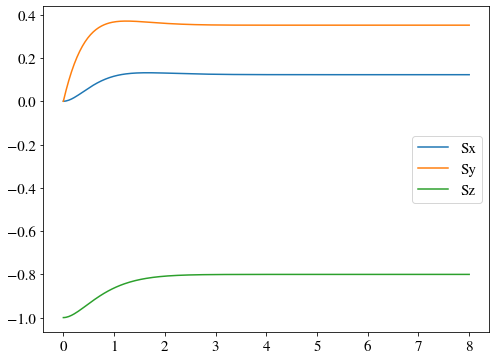

In [522]:
plt.plot(times,np.real(Sx_result),label="Sx")
plt.plot(times,np.real(Sy_result),label="Sy")
plt.plot(times,np.real(Sz_result),label="Sz")

plt.legend()

In [523]:
import qutip
from qutip.piqs import *

import numpy as np
from qutip import sigmax, sigmay, sigmaz,tensor, qeye, Qobj
from qutip import basis
from qutip import sesolve

import matplotlib.pyplot as plt

#times1=times 
times1=times

n=N

def arraygen(n,A):
    Arr=[]
    for j in range(n):
        Arr.append(A)
    return Arr


def S_k(k,n=n):
    
    h=0*qeye(2**n)
    if k==0:
            
        for i in range(n):
            Arr=arraygen(n,qeye(2))
            Arr[i]=sigmax()
            h=np.add(h,tensor(Arr))
    elif k==1:
        for i in range(n):
            Arr=arraygen(n,qeye(2))
            Arr[i]=sigmay()
            h=np.add(h,tensor(Arr))
    elif k==2:
        for i in range(n):
            Arr=arraygen(n,qeye(2))
            Arr[i]=sigmaz()
            h=np.add(h,tensor(Arr))
    
    elif k=="-":
        for i in range(n):
            Arr=arraygen(n,qeye(2))
            sminus=(sigmax()-1j*sigmay())/2
            Arr[i]=sminus
            h=np.add(h,tensor(Arr))
        
        
    
    return h/2
    

    
def matrix_dec(k,index,rate):
    h=0*qeye(2**N)
    sminus=(sigmax()-1j*sigmay())/2

    if k=="z":
        
        Arr=arraygen(N,qeye(2))
        Arr[index]=sigmaz()
        
        return Qobj(np.sqrt(rate)*np.add(h,tensor(Arr)))
    
    elif k=="-":
            
        Arr=arraygen(N,qeye(2))
        Arr[index]=sminus
        
        return Qobj(np.sqrt(rate)*np.add(h,tensor(Arr)))
    
    
    
    
def unc_list(k,rate):
    unc_list=[]
    for j in range(N):
        unc_list.append(matrix_dec(k,j,rate))
    
    return unc_list 
    
    
    
    
import matplotlib.pyplot as plt
import time

t0=time.time()

#psi_init=np.cos(np.pi/4)*(basis(2,0)+basis(2,1))
psi_init=basis(2,1)
psi0=Qobj(tensor(arraygen(n,psi_init)))

H=Qobj( (2*(J/n)*S_k(2,n)*S_k(2,n)+Omega*S_k(0,n))  )


#Use for unitary dynamics solely

#result=result()

In [524]:
from qutip import mesolve
#result = mesolve(H, psi0, times, [np.sqrt(0.04) * Qobj(S_k(2,n))], [Qobj(S_k(0,n)),Qobj(S_k(1,n)),Qobj(S_k(2,n))])

#Collapsing_Operators= unc_list("z",Gamma_phi/2)+unc_list("-",Gamma_decay) 

Xcuad=Qobj(S_k(0,N))**2
Ycuad=Qobj(S_k(1,N))**2
Zcuad=Qobj(S_k(2,N))**2

Expected_Operators= [Qobj(S_k(0,n)),Qobj(S_k(1,n)),Qobj(S_k(2,n)),Xcuad,Ycuad,Zcuad]


#Gamma_phi_C=Gamma_phi
#Gamma_C=Gamma_decay

Gamma_phi_C=2*refgamma*J
Gamma_C=4*refgammadecay*J


Collapsing_Operators= [np.sqrt(Gamma_phi_C)*Qobj(S_k(2,N)),np.sqrt(Gamma_C)*Qobj(S_k("-",N))]  #Collective


result1 = mesolve(H, psi0, times, Collapsing_Operators, Expected_Operators)


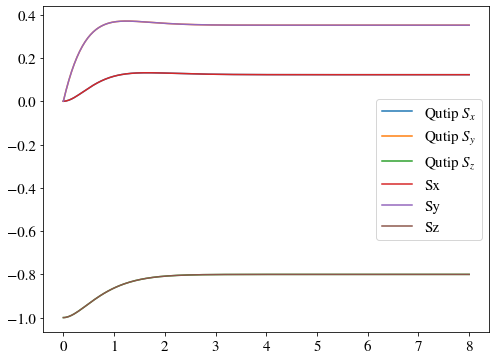

In [525]:
plt.plot(times, result1.expect[0],label="Qutip $S_x$")
plt.plot(times, result1.expect[1],label="Qutip $S_y$")
plt.plot(times, result1.expect[2],label="Qutip $S_z$")

plt.plot(times,np.real(Sx_result),label="Sx")
plt.plot(times,np.real(Sy_result),label="Sy")
plt.plot(times,np.real(Sz_result),label="Sz")

plt.legend()

In [526]:
Gamma_C

4

In [493]:
S_k("-",1)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 0.]
 [0. 0.]]